In [1]:

import numpy as np
import math
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import jpholiday
import pickle
from ydata_profiling import ProfileReport
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')


# pandasの表示を設定
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 300

In [2]:
train = pd.read_csv('train.csv', encoding='utf-8')
search_specified = pd.read_csv('search_specified.csv', encoding='utf-8')
search_unspecified = pd.read_csv('search_unspecified.csv', encoding='utf-8')
road = pd.read_csv('road_local.csv', encoding='utf-8')

### テーブルのマージと特徴量の追加

In [3]:
# day_of_week, day_of_year, holiday, tomorrow_holiday, yesterday_holidayを追加
def is_holiday(date):
    
    return (date.weekday() >= 5) or jpholiday.is_holiday(date)


def set_flags(df):
    
    df['tomorrow'] = df['date'] + pd.to_timedelta(1, 'd')
    df['day_of_week'] = df['date'].dt.weekday
    
    holidays = df['date'].apply(jpholiday.is_holiday)

    df['holiday'] = ((df['day_of_week'] >= 5) | holidays).astype(int)
    df['tomorrow_holiday'] = ((df['tomorrow'].dt.weekday >= 5) | holidays.shift(-1)).astype(int)
    
    # 連休何日目か(n_of_holidays)を追加
    mask = df['holiday'] != df['holiday'].shift(1).fillna(0)
    df['n_of_holidays'] = df.groupby(mask.cumsum()).cumcount() + 1
    df.loc[df['holiday'] == 0, 'n_of_holidays'] = 0
    
    ## 連休の始まりを特定
    #df['holiday_start'] = ((df['holiday'] == 1) & (df['holiday'].shift(1) == 0)).astype(int)
    ## 連休の終わりを特定
    #df['holiday_end'] = ((df['holiday'] == 1) & (df['holiday'].shift(-1) == 0)).astype(int)
    ## 連休の中間を特定
    #df['holiday_mid'] = (df['holiday'] & ~(df['holiday_start'] | df['holiday_end'])).astype(int)
    #
    #df.loc[df['holiday_start'] == 1, 'holiday_sme'] = 1
    #df.loc[df['holiday_mid'] == 1, 'holiday_sme'] = 2
    #df.loc[df['holiday_end'] == 1, 'holiday_sme'] = 3
    #df['holiday_sme'].fillna(0, inplace=True)
    
    df = df.drop(['tomorrow'], axis=1)
    
    return df

search_unspecified['date'] = pd.to_datetime(search_unspecified['date'])

search_unspecified = set_flags(search_unspecified)

search_unspecified['day_of_year'] = search_unspecified['date'].dt.dayofyear

In [4]:

# datetime, dateをyear, month, day, hourに展開
# テーブルをマージ
# 不要なカラムを削除
def expand_datetime(df):
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
    if 'datetime' in df.columns:
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
    return df

train['datetime'] = pd.to_datetime(train['datetime'])
train['date'] = train['datetime'].dt.date
train['date'] = pd.to_datetime(train['date'])
search_specified['datetime'] = pd.to_datetime(search_specified['datetime'])
search_unspecified['date'] = pd.to_datetime(search_unspecified['date'])
search_specified['datetime'] -= pd.to_timedelta(1, 'd')
search_unspecified['date'] -= pd.to_timedelta(1, 'd')

train = expand_datetime(train)

train_merged = train.merge(search_specified, on=['datetime', 'start_code', 'end_code'], how='left')

train_merged = train_merged.merge(search_unspecified, on=['date', 'start_code', 'end_code'], how='left')

train_merged = train_merged.merge(road.drop(['start_name', 'end_name', 'start_KP', 'end_KP', 'start_pref_code', 'end_pref_code', 'start_lat', 'end_lat', 'start_lng', 'end_lng', 'start_degree', 'end_degree', 'direction', 'road_code'], axis=1), on=['start_code', 'end_code'], how='left')

In [5]:
# section(始点IC-KP-終点IC)を追加しラベルエンコード
train_merged['section'] = train_merged['start_code'].astype(str) + '_' + train_merged['KP'].astype(str) + '_' + train_merged['end_code'].astype(str)

label_encoder = LabelEncoder()
train_merged['section'] = label_encoder.fit_transform(train_merged['section'])

with open('label.pickle', 'wb') as le:
    pickle.dump(label_encoder, le)

In [6]:
# 目的変数として翌日同時刻のspeed(speed_tomorrow)を追加
sub_df = train_merged[['datetime', 'section', 'speed']].rename(columns={'speed':'speed_tomorrow'})
sub_df['datetime'] -= pd.to_timedelta(1, 'd')
train_merged = pd.merge(train_merged, sub_df, on=['datetime', 'section'], how='left')


# weightの計算用に翌日同時刻のis_congestion(is_congestion_tomorrow)を追加
sub_df = train_merged[['datetime', 'section', 'is_congestion']].rename(columns={'is_congestion':'is_congestion_tomorrow'})
sub_df['datetime'] -= pd.to_timedelta(1, 'd')
train_merged = pd.merge(train_merged, sub_df, on=['datetime', 'section'], how='left')

train_merged = train_merged.loc[train_merged['speed_tomorrow'].notnull()]
train_merged = train_merged.loc[train_merged['is_congestion_tomorrow'].notnull()]
    

In [7]:
# hour, day_of_yearをsin, cos変換

def sin_cos_encoder(data, cols):

    for col in cols:
        data[f'{col}_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[f'{col}_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())

    return data


train_merged = sin_cos_encoder(train_merged, ['day_of_year'])

In [8]:
def moving_ave(x, size):
    
    x_mean = x.rolling(window=size).mean()
    
    return x_mean

In [9]:
## search_specifiedの同時刻同区間平均(search_specified_hour_mean)を追加
#train_merged['search_specified_hour_mean'] = train_merged.groupby(['hour', 'section'])['search_specified'].transform('mean')
#
## 同区間同曜日同時刻のsearch_specifiedの平均
#train_merged['search_specified_same_dow_hour_mean'] = train_merged.groupby(['hour', 'day_of_week', 'section'])['search_specified'].transform('mean') 
#
# search_specifiedの同区間同日同時刻平均(search_specified_same_day_hour_mean)を追加
train_merged['search_specified_same_day_hour_mean'] = train_merged.groupby(['month', 'day', 'hour', 'section'])['search_specified'].transform('mean')     
train_merged['search_specified'].fillna(train_merged['search_specified_same_day_hour_mean'], inplace=True)

In [10]:
## search_unspecifiedの同区間平均(search_unspecified_mean)を追加
#train_merged['search_unspecified_mean'] = train_merged.groupby(['section'])['search_unspecified'].transform('mean')
#
## 同区間同曜日のsearch_unspecifiedの平均
#train_merged['search_unspecified_same_dow_mean'] = train_merged.groupby(['day_of_week', 'section'])['search_unspecified'].transform('mean') 
#
# search_unspecifiedの同区間同日平均(search_unspecified_same_day_mean)を追加
train_merged['search_unspecified_same_day_mean'] = train_merged.groupby(['month', 'day', 'section'])['search_unspecified'].transform('mean')   
train_merged['search_unspecified'].fillna(train_merged['search_unspecified_same_day_mean'], inplace=True)

In [11]:
## 同区間のis_congestionの平均
#train_merged['congestion_mean'] = train_merged.groupby(['section'])['is_congestion'].transform('mean')

# 同区間同時刻のis_congestionの平均
train_merged['congestion_hour_mean'] = train_merged.groupby(['hour', 'section'])['is_congestion'].transform('mean')

## 同区間同曜日同時刻のis_congestionの平均
#train_merged['congestion_same_dow_hour_mean'] = train_merged.groupby(['hour', 'day_of_week', 'section'])['is_congestion'].transform('mean')

## 同区間同日のis_congestionの平均
#train_merged['congestion_same_day_mean'] = train_merged.groupby(['month', 'day', 'section'])['is_congestion'].transform('mean')

## 同区間同日時同時刻のis_congestionの平均
#train_merged['congestion_same_day_hour_mean'] = train_merged.groupby(['month', 'day', 'hour', 'section'])['is_congestion'].transform('mean')

In [12]:
## OCCの同時刻平均(OCC_hour_mean)を追加
#train_merged['OCC_hour_mean'] = train_merged.groupby(['hour', 'section'])['OCC'].transform('mean')
#
## 同区間同曜日同時刻のOCCの平均
#train_merged['OCC_same_dow_hour_mean'] = train_merged.groupby(['hour', 'day_of_week', 'section'])['OCC'].transform('mean')

# OCCの同日同時刻平均(OCC_same_day_hour_mean)を追加
train_merged['OCC_same_day_hour_mean'] = train_merged.groupby(['month', 'day', 'hour', 'section'])['OCC'].transform('mean')

# OCCの同時刻7日移動平均(speed_hour_move_ave_nd)を追加
train_merged['OCC_hour_move_ave_7d'] = train_merged.groupby(['hour', 'section'])['OCC'].transform(lambda x: moving_ave(x, 7))

In [13]:
## speedの同時刻平均(speed_hour_mean)を追加
#train_merged['speed_hour_mean'] = train_merged.groupby(['hour', 'section'])['speed'].transform('mean')

# 同区間同日のspeedの平均
train_merged['speed_same_day_mean'] = train_merged.groupby(['month' ,'day', 'section'])['speed'].transform('mean')

## 同区間同曜日同時刻のspeedの平均
#train_merged['speed_same_dow_hour_mean'] = train_merged.groupby(['hour', 'day_of_week', 'section'])['speed'].transform('mean')

# speedの同日同時刻平均(speed_same_day_hour_mean)を追加
train_merged['speed_same_day_hour_mean'] = train_merged.groupby(['month', 'day', 'hour', 'section'])['speed'].transform('mean')

# speedの同時刻7日移動平均(speed_hour_move_ave_nd)を追加
train_merged['speed_hour_move_ave_7d'] = train_merged.groupby(['hour', 'section'])['speed'].transform(lambda x: moving_ave(x, 7))

#speedの同時刻7日移動平均に対する変化率を追加
train_merged['speed_change_hour_move_ave_7d'] = train_merged['speed'] / train_merged['speed_hour_move_ave_7d']

In [20]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5792668 entries, 0 to 5792667
Data columns (total 28 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   datetime                             object 
 1   start_code                           int64  
 2   end_code                             int64  
 3   KP                                   float64
 4   OCC                                  float64
 5   allCars                              int64  
 6   speed                                float64
 7   is_congestion                        int64  
 8   search_specified                     float64
 9   search_unspecified                   float64
 10  day_of_week                          float64
 11  holiday                              int64  
 12  tomorrow_holiday                     int64  
 13  n_of_holidays                        int64  
 14  section                              int64  
 15  speed_tomorrow                  

In [14]:
train_merged[['holiday', 'tomorrow_holiday', 'n_of_holidays', 'is_congestion_tomorrow']] = train_merged[['holiday', 'tomorrow_holiday', 'n_of_holidays', 'is_congestion_tomorrow']].astype(int)

In [15]:
train_merged['to_drop'] = ((train_merged['OCC'] < 2) & (train_merged['is_congestion'] == 1)).astype('int')

train_merged = train_merged.drop(train_merged[train_merged['to_drop'] == 1].index, axis=0)
train_merged = train_merged.drop(['year', 'date', 'month', 'day', 'hour', 'day_of_year', 'limit_speed', 'to_drop'], axis=1)

In [16]:
train_merged.to_csv('train_merged.csv', index=False)
train_merged = pd.read_csv('train_merged.csv', encoding='utf-8')

In [17]:
train_merged_profile = ProfileReport(train_merged, title="Profiling Report:Train Merged", minimal=True)
train_merged_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
train_merged.columns

Index(['datetime', 'start_code', 'end_code', 'KP', 'OCC', 'allCars', 'speed',
       'is_congestion', 'search_specified', 'search_unspecified',
       'day_of_week', 'holiday', 'tomorrow_holiday', 'n_of_holidays',
       'section', 'speed_tomorrow', 'is_congestion_tomorrow',
       'day_of_year_sin', 'day_of_year_cos',
       'search_specified_same_day_hour_mean',
       'search_unspecified_same_day_mean', 'congestion_hour_mean',
       'OCC_same_day_hour_mean', 'OCC_hour_move_ave_7d', 'speed_same_day_mean',
       'speed_same_day_hour_mean', 'speed_hour_move_ave_7d',
       'speed_change_hour_move_ave_7d'],
      dtype='object')

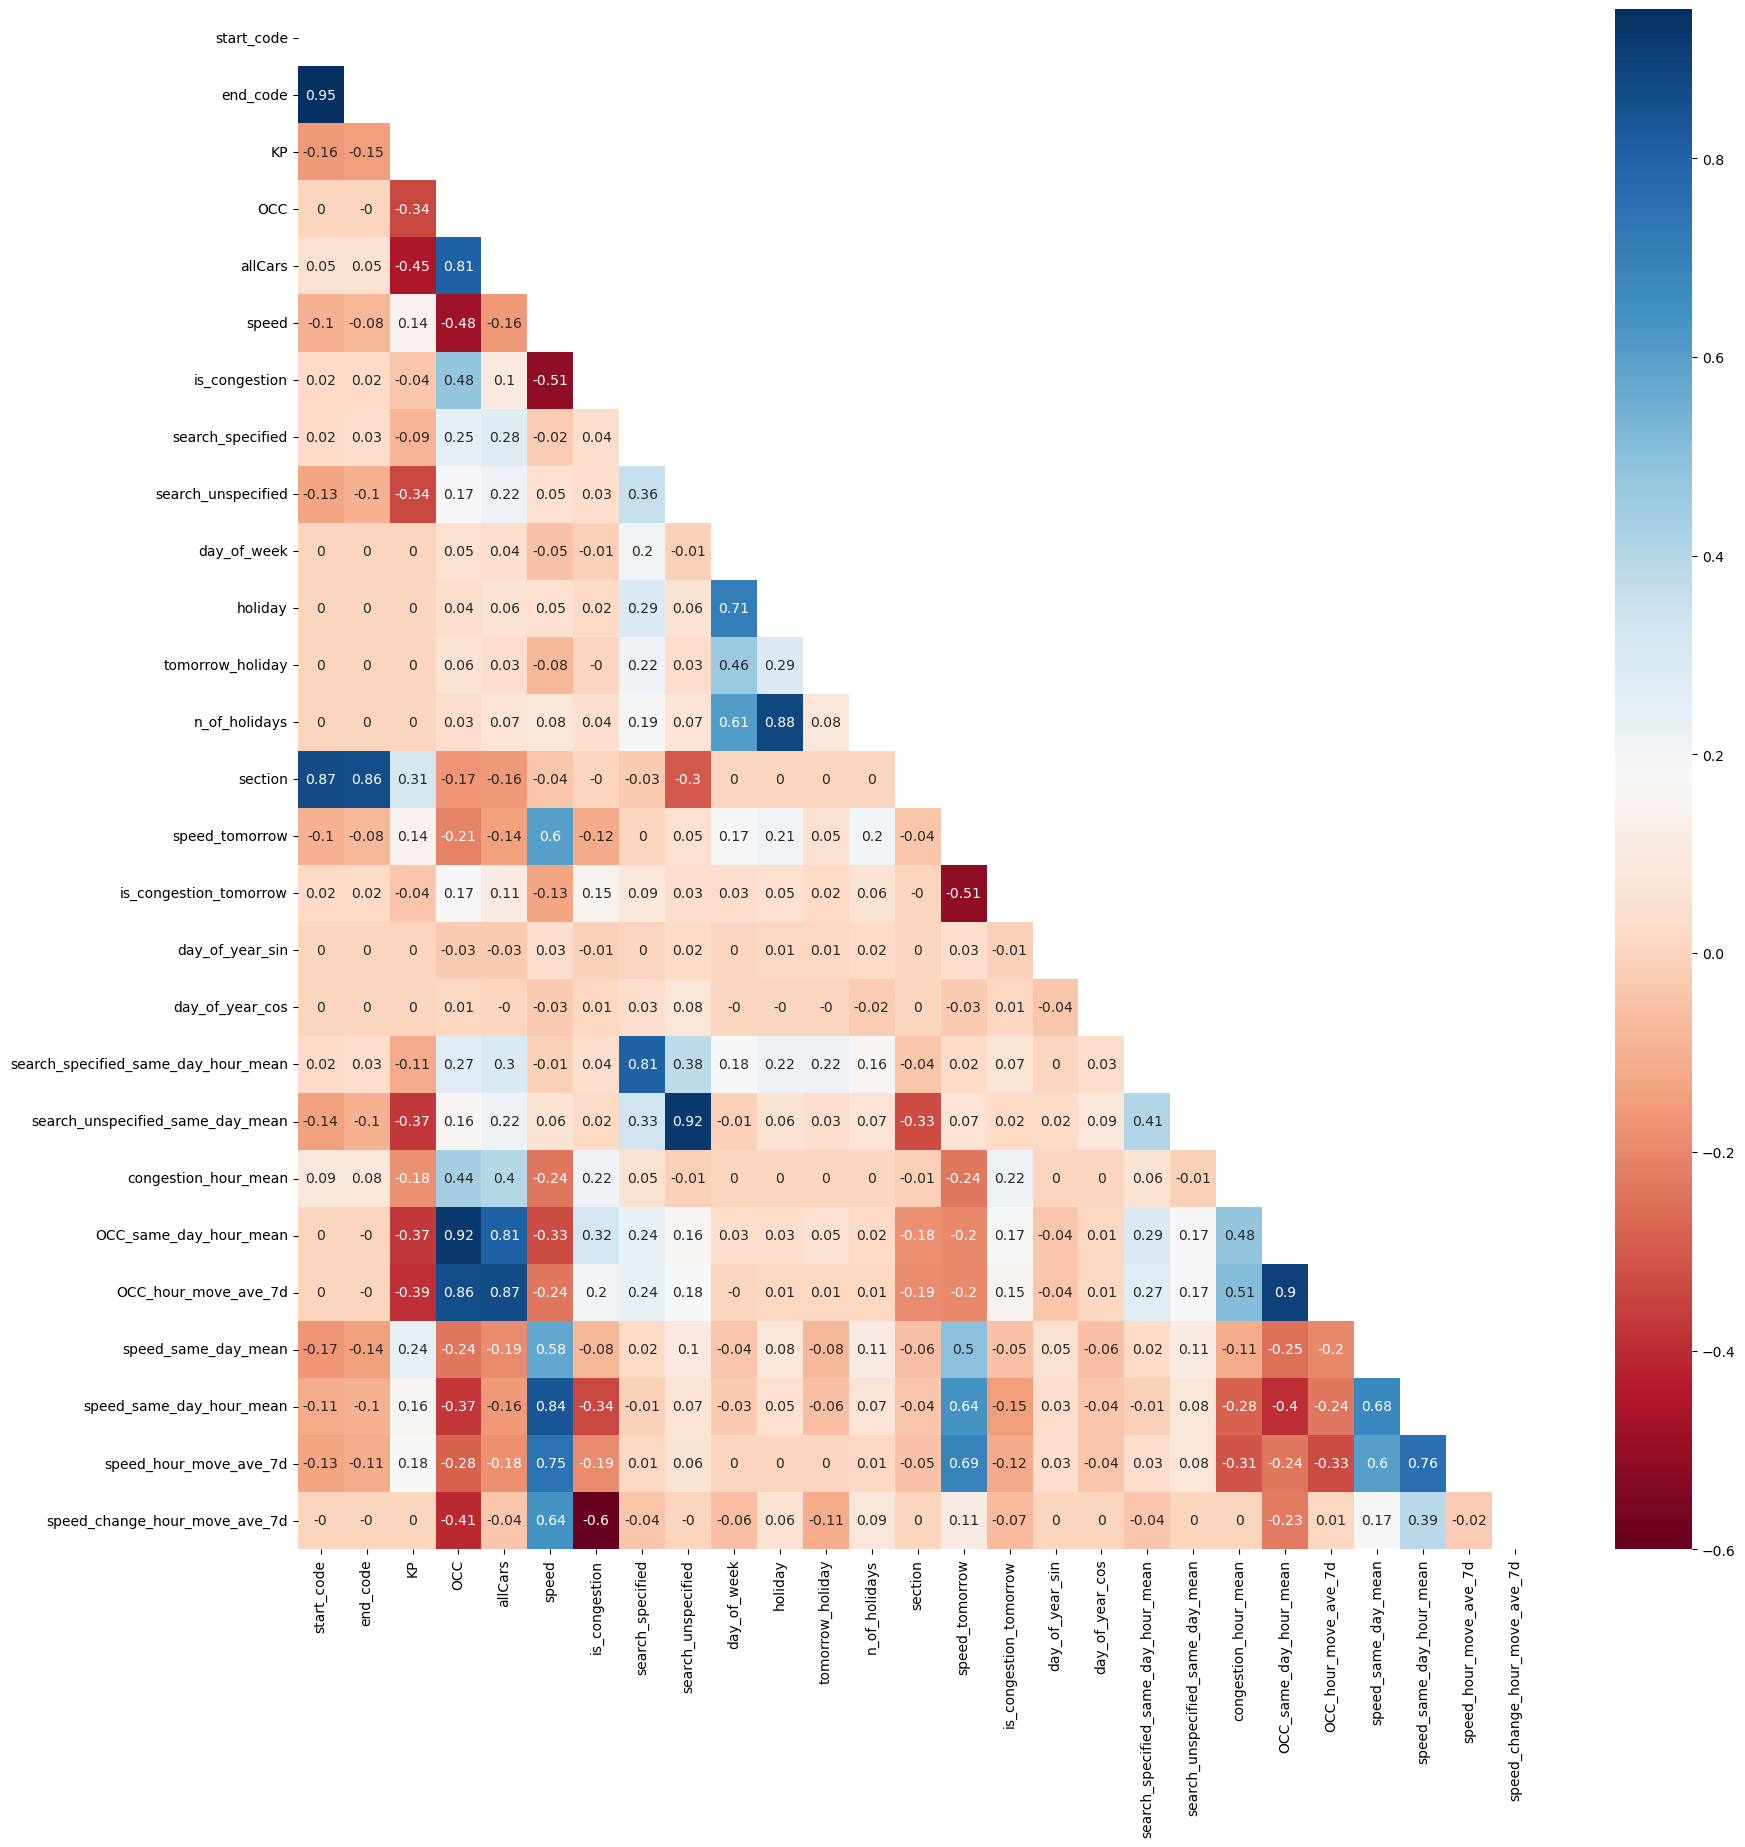

In [19]:
%matplotlib inline

corr_df = train_merged.corr().round(2)

mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask, k=0)] = True

plt.figure(figsize=(20,20))
ax = sns.heatmap(corr_df, cmap="RdBu", annot=True, mask=mask)

plt.show()